# Parallel computing with dask

## Authors & Contributors
### Authors
- Tina Odaka, Ifremer (France), [@tinaok](https://github.com/tinaok)
### Contributors
- Pier Lorenzo Marasco, Ispra (Italy), [@pl-marasco](https://github.com/pl-marasco)

<div class="alert alert-info">
<i class="fa-question-circle fa" style="font-size: 22px;color:#666;"></i> Overview
    <br>
    <br>
    <b>Questions</b>
    <ul>
        <li>What is Dask?</li>
        <li>How can I parallelize my data analysis with dask?</li>
    </ul>
    <b>Objectives</b>
    <ul>
        <li>Learn about dask</li>
        <li>Learn about dask gateway, dask client and dask worker</li>
        <li>Understand out-of-core and speed-up limitations</li>
    </ul>
</div>

## Context


We will be using [dask](https://docs.dask.org/) with Xarray to parallelize our data analysis. The analysis is very similar to what we have done in previous episodes but this time we will use data on a global coverage that we read from a shared catalog (stored online in the Pangeo EOSC OpenStack Object Storage).

### Data

In this episode, we will be using Global Long Term Statistics (1999-2019) product provided by the [Copernicus Global Land Service over Lombardia](https://land.copernicus.eu/global/index.html) and access them through [S3-comptabile storage](https://en.wikipedia.org/wiki/Amazon_S3) ([OpenStack Object Storage "Swift")](https://wiki.openstack.org/wiki/Swift) with a data catalog we have created and made publicly available.

## Setup

This episode uses the following Python packages:

- pooch
- s3fs
- xarray
- netcdf4
- h5netcdf
- hvplot
- dask
- numpy
- pandas
- geopandas

Please install these packages if not already available in your Python environment. Below, we only install packages that are not available in the EGI-ACE EOSC deployment of Pangeo for the FOSS4G course.

### Packages

In this episode, Python packages are imported when we start to use them. However, for best software practices, we recommend you to install and import all the necessary libraries at the top of your Jupyter notebook.

## Parallelize with Dask

We know that chunking is key for analyzing large datasets and in this episode, we will learn to parallelize our data analysis using dask.

### What is Dask?

**Dask** accelerates the existing Python ecosystem: with very or no changes in your code, you can speed-up computation using Dask.

- Dask is a flexible library for parallel computing in Python.
- It is widely used for getting the necessary performance when handling large and complex Earth Science datasets.
- Dask is powerful, scalable and flexible. It is the leading platform today for analytics.
- It scales natively to clusters, cloud and bridges prototyping up to production.
- The strength of Dask is that is accelerates the existing Python ecosystem e.g. Numpy, Pandas and Scikit-learn with few effort from end-users.

#### How does Dask accelerate your data analysis?

- Dask chunks your big datasets and this is how we can easily parallelize and scale.

For instance, dask can chunk a large numpy array into smaller ones and compute each chunk independently.

![Dask and Numpy](https://examples.dask.org/_images/dask-array-black-text.svg)

The same applies for `Xarray`.

#### How does Xarray with dask distribute data analysis?

When we use chunks with `Xarray`, the real computation is only done when needed; for instance when invoking `compute()` function. Dask generates a **task graph** describing the computation to be done and a **scheduler** executes these tasks across several **workers**.

![Xarray with dask](../figures/dask-xarray-explained.png)

## Set up dask gateway

There are different ways to use dask depending on the underlying infrastructure. In the Pangeo EOSC you are using for this workshop, we have the possibility to set up dask gateways to manage dask clusters and run our data analysis in parallel e.g. distribute tasks across several workers. 

In [1]:
from dask_gateway import Gateway
gateway = Gateway(
    "http://api-daskhub-dask-gateway.daskhub:8000/",
)

## Create a new cluster

In [2]:
cluster = gateway.new_cluster()
cluster.scale(4)
cluster

## Get a client from the Dask Gateway Cluster
The Dask client is what allows you to interact with Dask. 
The Client will create the Directed Acyclic Graph (DAG) of tasks by analysing the code, and will be responsible for telling the scheduler what to compute. It will also gather results from the workers and aggregates the results in the Client process.

In [3]:
from distributed import Client

if cluster:
    client = Client(cluster) # create a dask Gateway cluster
else:
    client = Client()   # create a local dask cluster on the machine.
client

/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py:1274: VersionMismatchWarning: Mismatched versions found

+-------------+----------+-----------+---------+
| Package     | client   | scheduler | workers |
+-------------+----------+-----------+---------+
| dask        | 2022.7.0 | 2022.6.0  | None    |
| distributed | 2022.7.0 | 2022.6.0  | None    |
| lz4         | 4.0.0    | None      | None    |
| toolz       | 0.12.0   | 0.11.2    | None    |
+-------------+----------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/daskhub.5426bb29b7f94d24938f8cfcba57e45d/status,


:::{tip}
A Dask client can also be created on a single machine (for instance your laptop) e.g. there is no need to have dedicated computational resources. However, speedup will not be possible if you do not have dedicated computational resources!
:::

## Open a single file for parallel processing

We will first open a sngle file: we use the same syntax as earlier but this time, we pass an additional parameter `chunks` to explicitely define how the chunking (and then parallel computing) needs to be done. 
- `-1` for time means the dataset is loaded with dask using a single chunk for all arrays;
- `auto` will use dask auto chunking taking into account the engine preferred chunks

In [4]:
import xarray as xr
import s3fs

In [5]:
fs = s3fs.S3FileSystem(anon=True,
      client_kwargs={
         'endpoint_url': 'https://object-store.cloud.muni.cz'
      })

In [6]:
%%time
s3path = 's3://foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-1221_GLOBE_VGT-PROBAV_V3.0.1.nc'
LTS = xr.open_dataset(fs.open(s3path), chunks={'time':-1, 'lat':'auto', 'lon':5000})
LTS

CPU times: user 535 ms, sys: 91.8 ms, total: 627 ms
Wall time: 966 ms


<xarray.Dataset>
Dimensions:  (lon: 40320, lat: 15680)
Coordinates:
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 80.0 79.99 79.98 79.97 ... -59.97 -59.98 -59.99
Data variables:
    crs      |S1 ...
    min      (lat, lon) float32 dask.array<chunksize=(3920, 5000), meta=np.ndarray>
    median   (lat, lon) float32 dask.array<chunksize=(3920, 5000), meta=np.ndarray>
    max      (lat, lon) float32 dask.array<chunksize=(3920, 5000), meta=np.ndarray>
    mean     (lat, lon) float32 dask.array<chunksize=(3920, 5000), meta=np.ndarray>
    stdev    (lat, lon) float32 dask.array<chunksize=(3920, 5000), meta=np.ndarray>
    nobs     (lat, lon) float32 dask.array<chunksize=(3920, 5000), meta=np.ndarray>
Attributes: (12/19)
    Conventions:          CF-1.6
    parent_identifier:    urn:cgls:global:ndvi_stats_all
    identifier:           urn:cgls:global:ndvi_stats_all:NDVI-LTS_1999-2019-1...
    long_name:            Normalized Difference Vegetation Index
    title:                Normalized Difference Vegetation Index: Long Term S...
    product_version:      V3.0.1
    ...                   ...
    source:               Derived from EO satellite imagery
    processing_mode:      Offline
    references:           https://land.copernicus.eu/global/products/ndvi
    copyright:            Copernicus Service information 2021
    archive_facility:     VITO
    history:              2021-03-01 - Processing line NDVI LTS

## Select a single location and visualize the task graph 

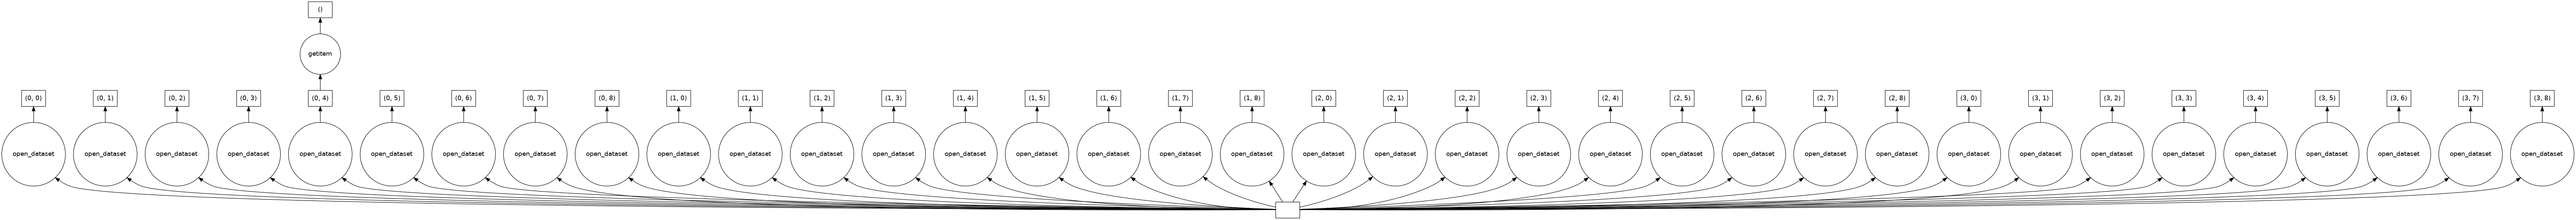

In [7]:
save=LTS.sel(lat=45.50, lon=9.36, method='nearest')['min']
save.data.visualize()

If you look to the task graph, you can see that only one dask worker need to read the data so most dask workers are doing some useless reads of data. 
We optimise, and verify the graph.

## Optimize the task graph

In [8]:
import dask

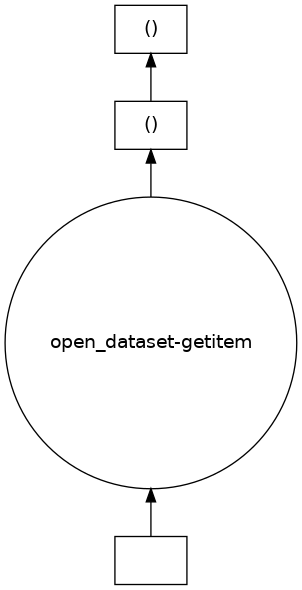

In [9]:
(save,)=dask.optimize(save)
save.data.visualize()

## Install missing packages on the dask workers
The workers have their own conda environment, independent from what we have in our notebook. Most of the time, the workers do not have many Python packages installed by default (this is often not needed). Therefore, to be able to compute anything, we need to make sure the packages needed for the corresponding computation are available on the worker of the dask cluster. If not, using `.compute()` will fail.

In [10]:
from distributed.diagnostics.plugin import PipInstall

extra_packages=["xarray", "netCDF4", "s3fs", "h5netcdf", "zarr"]

plugin=PipInstall(extra_packages,restart=True)
client.register_worker_plugin(plugin)

{'tls://10.244.1.61:35993': {'status': 'OK'},
 'tls://10.244.1.62:38759': {'status': 'OK'},
 'tls://10.244.1.63:37379': {'status': 'OK'},
 'tls://10.244.1.64:40691': {'status': 'OK'}}

Verify the installation of package on dask worker.

In [11]:
client.get_versions(packages=extra_packages,check=True)

/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py:4239: UserWarning: Mismatched versions found

+-------------+----------+-----------+---------+
| Package     | client   | scheduler | workers |
+-------------+----------+-----------+---------+
| dask        | 2022.7.0 | 2022.6.0  | None    |
| distributed | 2022.7.0 | 2022.6.0  | None    |
| lz4         | 4.0.0    | None      | None    |
| toolz       | 0.12.0   | 0.11.2    | None    |
+-------------+----------+-----------+---------+
  warnings.warn(msg["warning"])


{'scheduler': {'host': {'python': '3.10.5.final.0',
   'python-bits': 64,
   'OS': 'Linux',
   'OS-release': '5.4.0-109-generic',
   'machine': 'x86_64',
   'processor': '',
   'byteorder': 'little',
   'LC_ALL': 'None',
   'LANG': 'C.UTF-8'},
  'packages': {'python': '3.10.5.final.0',
   'dask': '2022.6.0',
   'distributed': '2022.6.0',
   'msgpack': '1.0.4',
   'cloudpickle': '2.1.0',
   'tornado': '6.1',
   'toolz': '0.11.2',
   'numpy': '1.22.4',
   'pandas': None,
   'lz4': None,
   'xarray': None,
   'netCDF4': None,
   's3fs': None,
   'h5netcdf': None,
   'zarr': None}},
 'workers': {},
 'client': {'host': {'python': '3.9.13.final.0',
   'python-bits': 64,
   'OS': 'Linux',
   'OS-release': '5.4.0-109-generic',
   'machine': 'x86_64',
   'processor': 'x86_64',
   'byteorder': 'little',
   'LC_ALL': 'C.UTF-8',
   'LANG': 'C.UTF-8'},
  'packages': {'python': '3.9.13.final.0',
   'dask': '2022.7.0',
   'distributed': '2022.7.0',
   'msgpack': '1.0.4',
   'cloudpickle': '2.1.0',
  

## Compute on the dask workers

In [12]:
save.compute()

<xarray.DataArray 'min' ()>
array(0.19200002, dtype=float32)
Coordinates:
    lon      float64 9.357
    lat      float64 45.5
Attributes:
    standard_name:  normalized_difference_vegetation_index
    long_name:      Minimum Normalized Difference Vegetation Index over time ...
    grid_mapping:   crs
    flag_meanings:  sea no_data
    flag_values:    [254 255]
    units:          
    valid_range:    [  0 250]
    cell_methods:   area: mean time: minimum

## Global LTS

In the previous episode, we used Long-term Timeseries for the region of Lombardy e.g. a very small area. Now we would like to use the original dataset that has a global coverage. Let's first open one single file (for January 1999-2019) to understand how much larger the global dataset is.

## Read from online catalog
The catalog can be shared on cloud and load it from there too. We will access Long Term TimeSeries of NDVI statistics from OpenStack Object Storage through the kerchunked catalog (see previous episode on catalogs).

In [13]:
import pandas as pd
import numpy as np

In [14]:
catalogue="https://object-store.cloud.muni.cz/swift/v1/foss4g-catalogue/c_gls_NDVI-LTS_1999-2019.json"
LTS = xr.open_mfdataset(
    "reference://", engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo":catalogue
                    },
        "consolidated": False
    }
)
LTS

,Array,Chunk
Bytes,84.79 GiB,14.28 MiB
Shape,"(36, 15680, 40320)","(1, 1207, 3102)"
Count,6085 Tasks,6084 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,84.79 GiB,14.28 MiB
Shape,"(36, 15680, 40320)","(1, 1207, 3102)"
Count,6085 Tasks,6084 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


### Fix time coordinate

In [15]:
dates_2022 = pd.date_range('20220101', '20221231')
decadie = dates_2022[np.isin(dates_2022.day, [1,11,21])]
LTS = LTS.assign_coords(time=decadie)
LTS

,Array,Chunk
Bytes,84.79 GiB,14.28 MiB
Shape,"(36, 15680, 40320)","(1, 1207, 3102)"
Count,6085 Tasks,6084 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,84.79 GiB,14.28 MiB
Shape,"(36, 15680, 40320)","(1, 1207, 3102)"
Count,6085 Tasks,6084 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


## Clip LTS over Lombardia

As in previous episodes, we use a shapefile over Lombardia to select data over this Area of Interest (AOI).

In [16]:
import geopandas as gpd

In [17]:
try:
    GAUL = gpd.read_file('Italy.geojson')
except:
    GAUL = gpd.read_file('zip+https://mars.jrc.ec.europa.eu/asap/files/gaul1_asap.zip') 

In [18]:
AOI_name = 'Lombardia'
AOI = GAUL[GAUL.name1 == AOI_name]
AOI_poly = AOI.geometry
AOI_poly

14    POLYGON ((10.23973 46.62177, 10.25084 46.61110...
Name: geometry, dtype: geometry

We first select a geographical area that covers Lombardia and then clip using the shapefile.

In [19]:
LTS = LTS.sel(lat=slice(46.5,44.5), lon=slice(8.5,11.5))

In [20]:
LTS = LTS.rio.write_crs(4326)

In [21]:
LTS = LTS.rio.clip(AOI_poly, crs=4326)

### Print metadata
We can print metadata without performing any computation yet. This is what we call *lazy* computation.

In [22]:
LTS

<xarray.Dataset>
Dimensions:  (lat: 203, lon: 327, time: 36)
Coordinates:
  * lat      (lat) float64 46.49 46.48 46.47 46.46 ... 44.71 44.71 44.7 44.69
  * lon      (lon) float64 8.509 8.518 8.527 8.536 ... 11.39 11.4 11.41 11.42
  * time     (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-12-21
    crs      int64 0
Data variables:
    max      (time, lat, lon) float32 dask.array<chunksize=(1, 203, 327), meta=np.ndarray>
    mean     (time, lat, lon) float32 dask.array<chunksize=(1, 203, 327), meta=np.ndarray>
    median   (time, lat, lon) float32 dask.array<chunksize=(1, 203, 327), meta=np.ndarray>
    min      (time, lat, lon) float32 dask.array<chunksize=(1, 203, 327), meta=np.ndarray>
    nobs     (time, lat, lon) float32 dask.array<chunksize=(1, 203, 327), meta=np.ndarray>
    stdev    (time, lat, lon) float32 dask.array<chunksize=(1, 203, 327), meta=np.ndarray>
Attributes: (12/19)
    Conventions:          CF-1.6
    archive_facility:     VITO
    copyright:            Copernicus Service information 2021
    history:              2021-03-01 - Processing line NDVI LTS
    identifier:           urn:cgls:global:ndvi_stats_all:NDVI-LTS_1999-2019-0...
    institution:          VITO NV
    ...                   ...
    references:           https://land.copernicus.eu/global/products/ndvi
    sensor:               VEGETATION-1, VEGETATION-2, VEGETATION
    source:               Derived from EO satellite imagery
    time_coverage_end:    2019-12-31T23:59:59Z
    time_coverage_start:  1999-01-01T00:00:00Z
    title:                Normalized Difference Vegetation Index: Long Term S...

## Compute

### Install additional packages in dask workers

In [23]:
extra_packages=["xarray", "netCDF4", "s3fs", "h5netcdf", "numpy", "zip", "pandas", "geopandas", "rioxarray", "rasterio", "scipy", "zarr"]

plugin=PipInstall(extra_packages,restart=True)
client.register_worker_plugin(plugin)

{'tls://10.244.1.61:34137': {'status': 'OK'},
 'tls://10.244.1.62:38107': {'status': 'OK'},
 'tls://10.244.1.63:35611': {'status': 'OK'},
 'tls://10.244.1.64:43357': {'status': 'OK'}}

CPU times: user 43.6 ms, sys: 31.1 ms, total: 74.6 ms
Wall time: 1.11 s


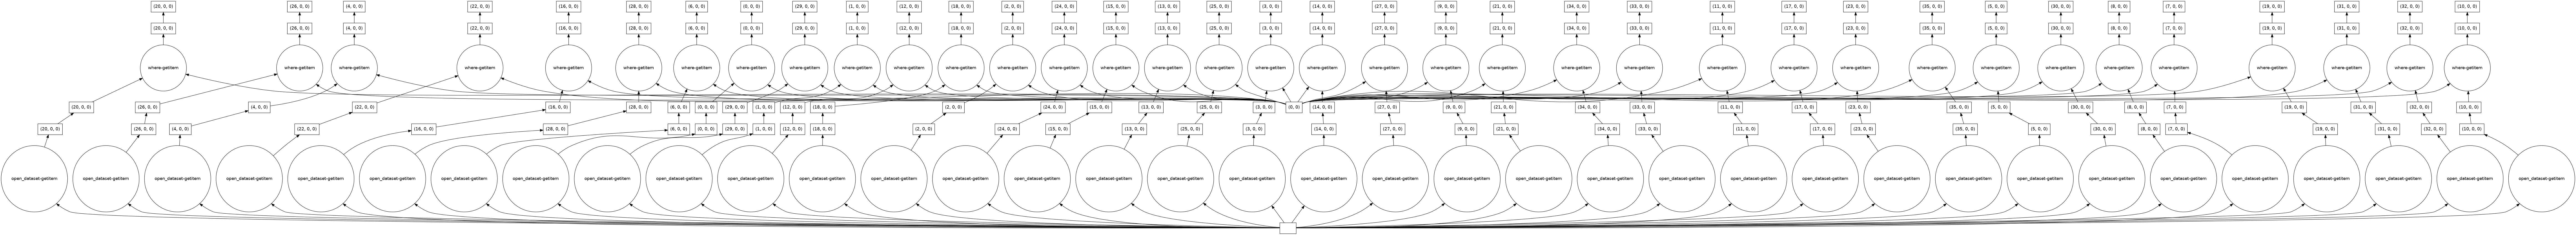

In [24]:
%%time
LTS_min = LTS['min']
(LTS_min,)=dask.optimize(LTS_min)
LTS_min.data.visualize()

In [ ]:
%%time
LTS_min.compute()

CPU times: user 43.5 ms, sys: 25.2 ms, total: 68.7 ms
Wall time: 1.13 s


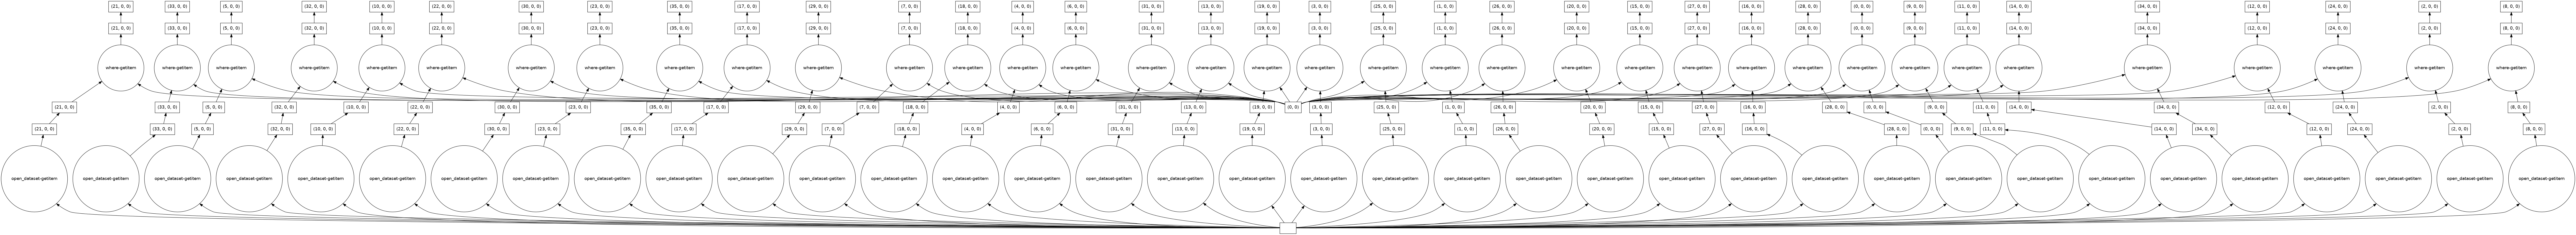

In [25]:
%%time
LTS_max = LTS['max']
(LTS_max,)=dask.optimize(LTS_max)
LTS_max.data.visualize()

In [ ]:
%%time
LTS_max.compute()

## Get NDVI for 2022 over Lombardia

We re-use the file we created during the first episode. If the file is missing it will be downloaded from Zenodo.

In [26]:
import pooch
try:
    cgls_ds = xr.open_dataset('C_GLS_NDVI_20220101_20220701_Lombardia_S3_2_masked.nc')
except:
    cgls_file = pooch.retrieve(
        url="https://zenodo.org/record/6969999/files/C_GLS_NDVI_20220101_20220701_Lombardia_S3_2_masked.nc",
        known_hash="md5:be3f16913ebbdb4e7af227f971007b22",
        path=f".",)    
    cgls_ds = xr.open_dataset(cgls_file)

In [27]:
cgls_ds

<xarray.Dataset>
Dimensions:  (time: 20, lon: 984, lat: 612)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-07-11
  * lon      (lon) float64 8.502 8.505 8.508 8.511 ... 11.42 11.42 11.42 11.43
  * lat      (lat) float64 46.5 46.5 46.49 46.49 ... 44.69 44.69 44.68 44.68
Data variables:
    NDVI     (time, lat, lon) float64 ...

In [28]:
NDVI_AOI = cgls_ds.NDVI.rio.write_crs(4326)

In [29]:
NDVI_AOI = NDVI_AOI.rio.clip(AOI_poly, crs=4326)

In [30]:
NDVI_AOI

<xarray.DataArray 'NDVI' (time: 20, lat: 612, lon: 984)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time         (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-07-11
  * lon          (lon) float64 8.502 8.505 8.508 8.511 ... 11.42 11.42 11.43
  * lat          (lat) float64 46.5 46.5 46.49 46.49 ... 44.69 44.69 44.68 44.68
    spatial_ref  int64 0

The nominal spatial resolution of the Long term statistics is 1km. As the current NDVI product has a nominal spatial resolution of 300m a re projection is needed. RioXarray through RasterIO that wraps the GDAL method can take care of this. More info about all the options can be found [here](https://rasterio.readthedocs.io/en/stable/api/rasterio.warp.html#rasterio.warp.reproject)

In [31]:
NDVI_1k = NDVI_AOI.rio.reproject_match(LTS)

In [32]:
NDVI_1k = NDVI_1k.rename({'x': 'lon', 'y':'lat'})

In [33]:
VCI = ((NDVI_1k - LTS['min']) / (LTS['max'] - LTS['min'])) * 100

In [34]:
VCI

<xarray.DataArray (time: 20, lat: 203, lon: 327)>
dask.array<mul, shape=(20, 203, 327), dtype=float64, chunksize=(1, 203, 327), chunktype=numpy.ndarray>
Coordinates:
  * lon          (lon) float64 8.509 8.518 8.527 8.536 ... 11.4 11.41 11.42
  * lat          (lat) float64 46.49 46.48 46.47 46.46 ... 44.71 44.7 44.69
  * time         (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-07-11
    spatial_ref  int64 0
    crs          int64 0

In [35]:
VCI.name = 'VCI'

In [36]:
VCI

<xarray.DataArray 'VCI' (time: 20, lat: 203, lon: 327)>
dask.array<mul, shape=(20, 203, 327), dtype=float64, chunksize=(1, 203, 327), chunktype=numpy.ndarray>
Coordinates:
  * lon          (lon) float64 8.509 8.518 8.527 8.536 ... 11.4 11.41 11.42
  * lat          (lat) float64 46.49 46.48 46.47 46.46 ... 44.71 44.7 44.69
  * time         (time) datetime64[ns] 2022-01-01 2022-01-11 ... 2022-07-11
    spatial_ref  int64 0
    crs          int64 0

In [37]:
%%time
VCI_c = VCI.compute()

KilledWorker: ('original-open_dataset-1a542200a7b7e2063c86d1de5bb0aa48max-cca9fd010ac6d1d6054049aaadd57dc0', <WorkerState 'tls://10.244.1.63:35611', name: dask-worker-5426bb29b7f94d24938f8cfcba57e45d-6k4gz, status: closed, memory: 0, processing: 18>)

In [38]:
VCI.isel(time=-1).plot()

KilledWorker: ('original-open_dataset-1a542200a7b7e2063c86d1de5bb0aa48min-258cab5a78e6b1bfb483440132fc083e', <WorkerState 'tls://10.244.1.65:35427', name: dask-worker-5426bb29b7f94d24938f8cfcba57e45d-klrl6, status: closed, memory: 0, processing: 4>)

Now you have catalogue, original data source, both on cloud space, thus even from daks workers which does not have access to your NFS local disk space, datas are accessible.
Now you are ready to parallelize your analysis using dask workers from dask gateway!

In [ ]:
client.shutdown()

<div class="alert alert-success">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Key Points</b>
    <br>
    <ul>
        <li>Chunking and compression</li>
        <li>Dask</li>
    </ul>
</div>